# Testing isostatic boundary conditions in UW2

This is a check to make sure UW2's pressure boundary condition properly works.

The setup is:

     <--------- 100 km ------------>
    _________________________________
    |                               |  ^
    |                               |  |
    |     compressible air          |  50 km 
    |        1 kg.m^-3              |  |
    |                               |  | 
    |_______________________________|  v 
    |        crust                  |  ^ 
    |        500 kg.m^-3            |  25 km 
    |_______________________________|  v 
    |        mantle                 |  ^ 
    |        1000 kg.m^-3           |  25 km 
    |_______________________________|  v 

We pull each vertical wall at 1 cm/yr (total extension is 2 cm/yr)
The top wall has a free slip boundary (no air can flow in or out of the top)
The bottom wall as a pressure boundary condition

If we pull long enough, we expect the crust material to thin to essentially
0 thickness, and that the surface will subside by some amount. 

Analytically, assuming the crust thickness has been thinned to 0, we get this 
formula to calculate the subsidence:

    h = ( rho_crust * a - rho_mantle * a ) / ( rho_air - rho_mantle )

where h is the subsidence amount, and a is the original thickness of the crust layer.

This calculation comes out to ~12.5 km of subsidence. If you run this model, you will
see the approximately same answer! Hooray!

Note: the model does encounter some velocity instabilities, but broadly seems to be correct.
With higher resolution, or smaller timesteps, it might be happier

In [1]:
import underworld as uw
import UWGeodynamics as GEO
import numpy as np
import matplotlib.pyplot as plt

loaded rc file /opt/UWGeodynamics/UWGeodynamics/uwgeo-data/uwgeodynamicsrc


In [2]:
u = GEO.UnitRegistry
GEO.rcParams['solver'] = "mumps"
GEO.rcParams["surface.pressure.normalization"] = True
GEO.rcParams["nonlinear.tolerance"] = 1e-3
GEO.rcParams["initial.nonlinear.tolerance"] = 1e-3
GEO.rcParams["minimum.viscosity"] = 1e18 * u.pascal * u.second
GEO.rcParams["maximum.viscosity"] = 1e24 * u.pascal * u.second

GEO.rcParams["penalty"] = 0  # must be 0, because we use compressible air
GEO.rcParams["element.type"] = "Q2/dQ1"
GEO.rcParams["advection.diffusion.method"] = "SLCN"
GEO.rcParams["CFL"] = 0.25

GEO.rcParams["popcontrol.split.threshold"] = 0.95
GEO.rcParams["popcontrol.max.splits"] = 100
GEO.rcParams["popcontrol.particles.per.cell.2D"] = 60
GEO.rcParams["swarm.particles.per.cell.2D"] = 60

In [ ]:
GEO.rcParams["output.directory"] = "simple_isos_1"

In [3]:
# Characteristic values of the system
half_rate = 1.0 * u.centimeter / u.year
model_length = 100e3 * u.meter
model_height = 100e3 * u.meter
refViscosity = 1e22 * u.pascal * u.second
bodyforce = 500 * u.kilogram / u.metre**3 * 9.81 * u.meter / u.second**2

KL = model_length
Kt = KL / half_rate
KM = bodyforce * KL**2 * Kt**2

GEO.scaling_coefficients["[length]"] = KL
GEO.scaling_coefficients["[time]"] = Kt
GEO.scaling_coefficients["[mass]"]= KM

In [4]:
divisor = 4
Model = GEO.Model(elementRes=(int(100/divisor),int(100/divisor)), 
                  minCoord=(-50 * u.kilometer, -50 * u.kilometer),
                  maxCoord=( 50 * u.kilometer,  50 * u.kilometer))

In [5]:
air = Model.add_material(name="air", shape=GEO.shapes.Layer2D(top=Model.top, bottom=0.0))
uc =  Model.add_material(name="crust",  shape=GEO.shapes.Layer2D(top=air.bottom, bottom=-25*u.kilometer))
mantle = Model.add_material(name="mantle",  shape=GEO.shapes.Layer2D(top=uc.bottom, bottom=Model.bottom))

air.density    =    1. * u.kilogram / u.metre**3
uc.density     =  500. * u.kilogram / u.metre**3
mantle.density = 1000. * u.kilogram / u.metre**3


air.viscosity    = 1e19 * u.pascal * u.second
uc.viscosity     = 1e21 * u.pascal * u.second  # make this slightly higher so UW has something to do
mantle.viscosity = 1e20 * u.pascal * u.second


# we need to make the air compressible, so we can put a free slip condition on the top
# of the model
air.compressibility = 1e3  # Not sure what's a good value

In [6]:
# We need to initialise the model first.
Model.init_model()

# This is where isostasy is imposed. We first calculate the lithostatic pressure along the entire
# bottom of the model. 
P, bottomPress = Model.get_lithostatic_pressureField()
# Then, since the model is laterally homogenous, we average it, and put it into megapascals
bottomPress = GEO.Dimensionalize(np.average(bottomPress), u.megapascal)

Model.set_velocityBCs(left=[-1.0 * u.centimetre / u.year, 0 * u.centimetre / u.year], 
                      right=[1.0 * u.centimetre / u.year, 0 * u.centimetre / u.year], 
                      top=[0 * u.centimetre / u.year , 0. * u.centimetre / u.year],  # notice the top is no slip
                      # This is where the pressure boundary is applied.
                      bottom=[None,bottomPress])

In [7]:
mswarm = uw.swarm.Swarm( mesh=Model.mesh, particleEscape=True )
msAdvector= uw.systems.SwarmAdvector(Model.velocityField, mswarm, order=4)

# initial height at 'air' level
particleCoordinates = np.zeros((1,2))
particleCoordinates[:,0] = 0
particleCoordinates[:,1] = 0
_ = mswarm.add_particles_with_coordinates(particleCoordinates)

height_through_time = []

In [8]:
def advect_passive():
    msAdvector.integrate(Model._dt)
    height_through_time.append((Model.time.magnitude, GEO.Dimensionalize(mswarm.particleCoordinates.data[:,1].copy()[0], u.kilometer).magnitude))
    #mswarm.[:,0] = 0  # reset back to centre
Model.postSolveHook = advect_passive


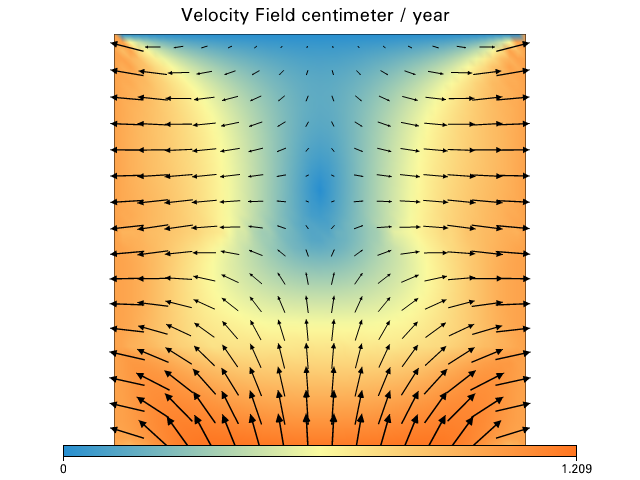


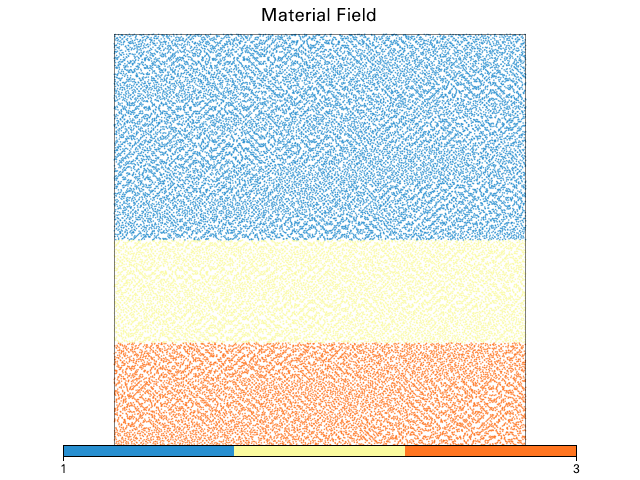

In [9]:
Model.solve()
Fig = Model.plot.velocityField()
Fig = Model.plot.material(projected=False, fn_size=2.0)

In [10]:
Model.run_for(5e6* u.year)

Running with UWGeodynamics version 0.9.3-dev-3c9372d(development)
Step:1 Model Time:  20678.74676 year dt: 20678.74676 year (2018-10-24 06:51:22)
Step:2 Model Time:  43944.5960473 year dt: 23265.8492873 year (2018-10-24 06:51:24)
Step:3 Model Time:  67208.0954555 year dt: 23263.4994082 year (2018-10-24 06:51:25)
Step:4 Model Time:  90087.23217 year dt: 22879.1367145 year (2018-10-24 06:51:26)
Step:5 Model Time:  112430.200711 year dt: 22342.9685405 year (2018-10-24 06:51:27)
Step:6 Model Time:  134021.433205 year dt: 21591.2324946 year (2018-10-24 06:51:28)
Step:7 Model Time:  156215.780672 year dt: 22194.3474664 year (2018-10-24 06:51:29)
Step:8 Model Time:  178088.60994 year dt: 21872.8292684 year (2018-10-24 06:51:30)
Step:9 Model Time:  200366.697007 year dt: 22278.0870666 year (2018-10-24 06:51:32)
Step:10 Model Time:  223819.593925 year dt: 23452.8969189 year (2018-10-24 06:51:33)
Step:11 Model Time:  247619.407731 year dt: 23799.8138053 year (2018-10-24 06:51:34)
Step:12 Model T

Step:97 Model Time:  2306337.81544 year dt: 24587.8567472 year (2018-10-24 06:53:18)
Step:98 Model Time:  2330974.72141 year dt: 24636.9059691 year (2018-10-24 06:53:19)
Step:99 Model Time:  2355568.24689 year dt: 24593.5254829 year (2018-10-24 06:53:21)
Step:100 Model Time:  2380179.14792 year dt: 24610.9010298 year (2018-10-24 06:53:22)
Step:101 Model Time:  2404677.77917 year dt: 24498.6312553 year (2018-10-24 06:53:24)
Step:102 Model Time:  2429225.28702 year dt: 24547.5078456 year (2018-10-24 06:53:25)
Step:103 Model Time:  2453839.58744 year dt: 24614.3004191 year (2018-10-24 06:53:26)
Step:104 Model Time:  2478504.85804 year dt: 24665.2705989 year (2018-10-24 06:53:28)
Step:105 Model Time:  2503223.17671 year dt: 24718.3186737 year (2018-10-24 06:53:29)
Step:106 Model Time:  2527905.38422 year dt: 24682.207505 year (2018-10-24 06:53:30)
Step:107 Model Time:  2552477.19443 year dt: 24571.8102097 year (2018-10-24 06:53:31)
Step:108 Model Time:  2575845.56618 year dt: 23368.3717529

Step:193 Model Time:  4643055.73485 year dt: 24804.6168114 year (2018-10-24 06:55:16)
Step:194 Model Time:  4667604.56952 year dt: 24548.8346634 year (2018-10-24 06:55:17)
Step:195 Model Time:  4692028.50318 year dt: 24423.9336686 year (2018-10-24 06:55:18)
Step:196 Model Time:  4716874.38611 year dt: 24845.88293 year (2018-10-24 06:55:19)
Step:197 Model Time:  4741617.64392 year dt: 24743.2578043 year (2018-10-24 06:55:20)
Step:198 Model Time:  4766478.16304 year dt: 24860.5191176 year (2018-10-24 06:55:21)
Step:199 Model Time:  4791258.30471 year dt: 24780.1416721 year (2018-10-24 06:55:23)
Step:200 Model Time:  4816076.71032 year dt: 24818.4056083 year (2018-10-24 06:55:24)
Step:201 Model Time:  4840915.2048 year dt: 24838.4944872 year (2018-10-24 06:55:25)
Step:202 Model Time:  4862499.41 year dt: 21584.2051963 year (2018-10-24 06:55:26)
Step:203 Model Time:  4887328.81401 year dt: 24829.4040113 year (2018-10-24 06:55:27)
Step:204 Model Time:  4910689.939 year dt: 23361.1249878 yea

1


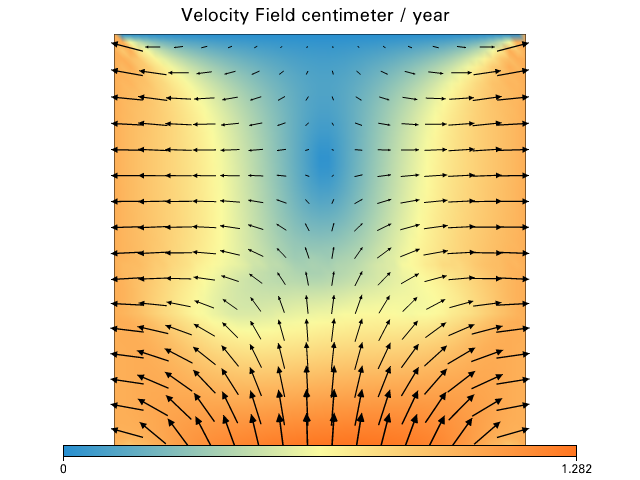


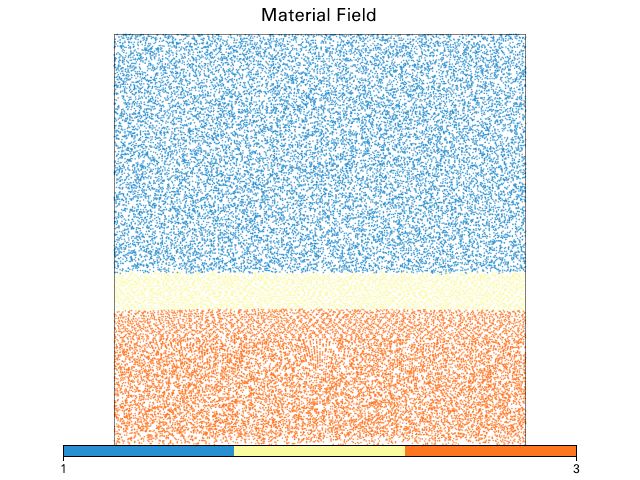

In [11]:
Fig = Model.plot.velocityField()
Fig = Model.plot.material(projected=False, fn_size=2.0)
np_htt = np.array(height_through_time)
plt.plot(np_htt[:,0], np_htt[:,1])

In [12]:
Model.run_for(5e6* u.year)

Running with UWGeodynamics version 0.9.3-dev-3c9372d(development)
Step:1 Model Time:  5024874.28277 year dt: 24874.282773 year (2018-10-24 06:55:38)
Step:2 Model Time:  5049712.00745 year dt: 24837.724674 year (2018-10-24 06:55:39)
Step:3 Model Time:  5071655.90624 year dt: 21943.8987912 year (2018-10-24 06:55:40)
Step:4 Model Time:  5096483.24526 year dt: 24827.3390235 year (2018-10-24 06:55:41)
Step:5 Model Time:  5120403.87369 year dt: 23920.6284259 year (2018-10-24 06:55:42)
Step:6 Model Time:  5145313.98817 year dt: 24910.1144835 year (2018-10-24 06:55:44)
Step:7 Model Time:  5168403.8893 year dt: 23089.9011335 year (2018-10-24 06:55:45)
Step:8 Model Time:  5193066.12675 year dt: 24662.2374447 year (2018-10-24 06:55:46)
Step:9 Model Time:  5216829.65559 year dt: 23763.5288426 year (2018-10-24 06:55:47)
Step:10 Model Time:  5241510.53148 year dt: 24680.8758887 year (2018-10-24 06:55:48)
Step:11 Model Time:  5265626.0134 year dt: 24115.4819152 year (2018-10-24 06:55:50)
Step:12 Mode

Step:97 Model Time:  7315052.9139 year dt: 24794.4262505 year (2018-10-24 06:57:34)
Step:98 Model Time:  7337752.95145 year dt: 22700.0375484 year (2018-10-24 06:57:35)
Step:99 Model Time:  7362624.46667 year dt: 24871.5152207 year (2018-10-24 06:57:36)
Step:100 Model Time:  7380336.88115 year dt: 17712.414481 year (2018-10-24 06:57:37)
Step:101 Model Time:  7405221.00813 year dt: 24884.1269837 year (2018-10-24 06:57:38)
Step:102 Model Time:  7425376.23314 year dt: 20155.2250044 year (2018-10-24 06:57:40)
Step:103 Model Time:  7450258.43936 year dt: 24882.2062251 year (2018-10-24 06:57:41)
Step:104 Model Time:  7473780.15754 year dt: 23521.7181787 year (2018-10-24 06:57:42)
Step:105 Model Time:  7498676.35462 year dt: 24896.1970808 year (2018-10-24 06:57:43)
Step:106 Model Time:  7519520.76822 year dt: 20844.413595 year (2018-10-24 06:57:45)
Step:107 Model Time:  7544421.48513 year dt: 24900.716917 year (2018-10-24 06:57:46)
Step:108 Model Time:  7565403.89369 year dt: 20982.4085617 ye

Step:193 Model Time:  9640925.62268 year dt: 22968.0665948 year (2018-10-24 06:59:49)
Step:194 Model Time:  9665844.01045 year dt: 24918.3877732 year (2018-10-24 06:59:50)
Step:195 Model Time:  9690716.66595 year dt: 24872.6554963 year (2018-10-24 06:59:51)
Step:196 Model Time:  9713540.10704 year dt: 22823.4410927 year (2018-10-24 06:59:53)
Step:197 Model Time:  9738481.68096 year dt: 24941.5739153 year (2018-10-24 06:59:54)
Step:198 Model Time:  9762488.61304 year dt: 24006.9320881 year (2018-10-24 06:59:56)
Step:199 Model Time:  9786014.8025 year dt: 23526.1894591 year (2018-10-24 06:59:57)
Step:200 Model Time:  9810937.44933 year dt: 24922.6468223 year (2018-10-24 06:59:59)
Step:201 Model Time:  9832184.02349 year dt: 21246.5741628 year (2018-10-24 07:00:01)
Step:202 Model Time:  9857077.21107 year dt: 24893.187585 year (2018-10-24 07:00:02)
Step:203 Model Time:  9878948.72996 year dt: 21871.5188875 year (2018-10-24 07:00:03)
Step:204 Model Time:  9903929.42001 year dt: 24980.69004

1


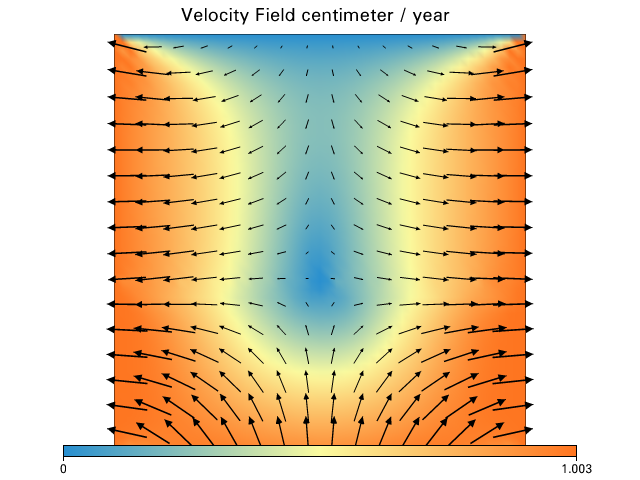


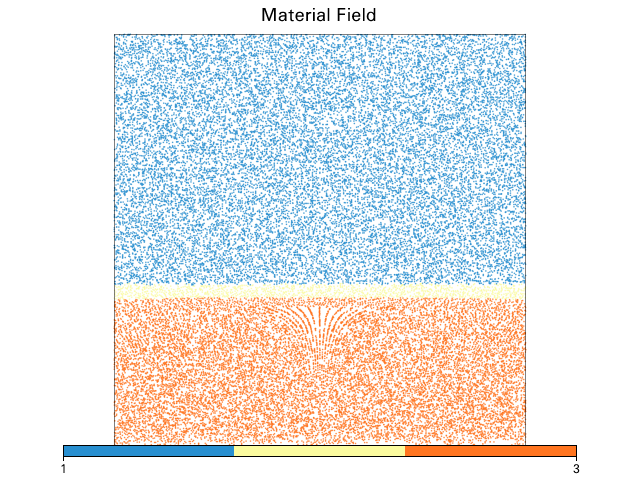

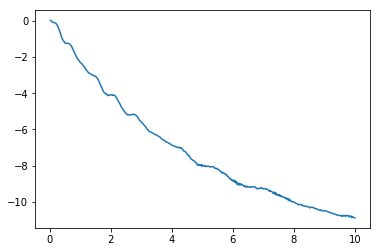

In [13]:
Fig = Model.plot.velocityField(rulers=True, rulerticks=5)
Fig = Model.plot.material(projected=False, fn_size=2.0,rulers=True, rulerticks=5)
np_htt = np.array(height_through_time)
plt.plot(np_htt[:,0], np_htt[:,1])

In [14]:
Model.run_for(5e6* u.year)

Running with UWGeodynamics version 0.9.3-dev-3c9372d(development)
Step:1 Model Time:  10024922.5738 year dt: 24922.5738116 year (2018-10-24 07:00:16)
Step:2 Model Time:  10047716.978 year dt: 22794.4042196 year (2018-10-24 07:00:18)
Step:3 Model Time:  10072678.7443 year dt: 24961.7662242 year (2018-10-24 07:00:20)
Step:4 Model Time:  10094040.4444 year dt: 21361.7001558 year (2018-10-24 07:00:21)
Step:5 Model Time:  10118902.6509 year dt: 24862.2064659 year (2018-10-24 07:00:22)
Step:6 Model Time:  10143485.1164 year dt: 24582.4655103 year (2018-10-24 07:00:23)
Step:7 Model Time:  10168410.0936 year dt: 24924.9772228 year (2018-10-24 07:00:24)
Step:8 Model Time:  10191629.4342 year dt: 23219.340613 year (2018-10-24 07:00:25)
Step:9 Model Time:  10216544.8132 year dt: 24915.3789823 year (2018-10-24 07:00:27)
Step:10 Model Time:  10237509.3715 year dt: 20964.5583187 year (2018-10-24 07:00:28)
Step:11 Model Time:  10262345.3993 year dt: 24836.0277569 year (2018-10-24 07:00:29)
Step:12 Mo

Step:98 Model Time:  12269460.48 year dt: 22562.1395669 year (2018-10-24 07:02:19)
Step:99 Model Time:  12294429.6227 year dt: 24969.142769 year (2018-10-24 07:02:20)
Step:100 Model Time:  12318633.6671 year dt: 24204.0443894 year (2018-10-24 07:02:21)
Step:101 Model Time:  12340678.9199 year dt: 22045.2527888 year (2018-10-24 07:02:22)
Step:102 Model Time:  12365655.8922 year dt: 24976.9722599 year (2018-10-24 07:02:23)
Step:103 Model Time:  12384890.0185 year dt: 19234.1263479 year (2018-10-24 07:02:25)
Step:104 Model Time:  12409890.0185 year dt: 25000.0 year (2018-10-24 07:02:26)
Step:105 Model Time:  12434388.933 year dt: 24498.9144383 year (2018-10-24 07:02:27)
Step:106 Model Time:  12459293.4321 year dt: 24904.499105 year (2018-10-24 07:02:29)
Step:107 Model Time:  12484282.5398 year dt: 24989.107728 year (2018-10-24 07:02:30)
Step:108 Model Time:  12505843.9863 year dt: 21561.4464711 year (2018-10-24 07:02:31)
Step:109 Model Time:  12530841.274 year dt: 24997.2876932 year (2018

Step:194 Model Time:  14502425.412 year dt: 20934.2120457 year (2018-10-24 07:04:22)
Step:195 Model Time:  14527299.4138 year dt: 24874.0018033 year (2018-10-24 07:04:23)
Step:196 Model Time:  14551902.2606 year dt: 24602.8467627 year (2018-10-24 07:04:24)
Step:197 Model Time:  14576822.3721 year dt: 24920.1114896 year (2018-10-24 07:04:26)
Step:198 Model Time:  14599561.4613 year dt: 22739.0892673 year (2018-10-24 07:04:27)
Step:199 Model Time:  14624508.4855 year dt: 24947.0241597 year (2018-10-24 07:04:28)
Step:200 Model Time:  14649141.584 year dt: 24633.0984917 year (2018-10-24 07:04:30)
Step:201 Model Time:  14674054.7103 year dt: 24913.1262979 year (2018-10-24 07:04:31)
Step:202 Model Time:  14699011.7992 year dt: 24957.0889041 year (2018-10-24 07:04:32)
Step:203 Model Time:  14721386.1232 year dt: 22374.324031 year (2018-10-24 07:04:34)
Step:204 Model Time:  14746231.7512 year dt: 24845.6279552 year (2018-10-24 07:04:35)
Step:205 Model Time:  14767601.6651 year dt: 21369.913949

1


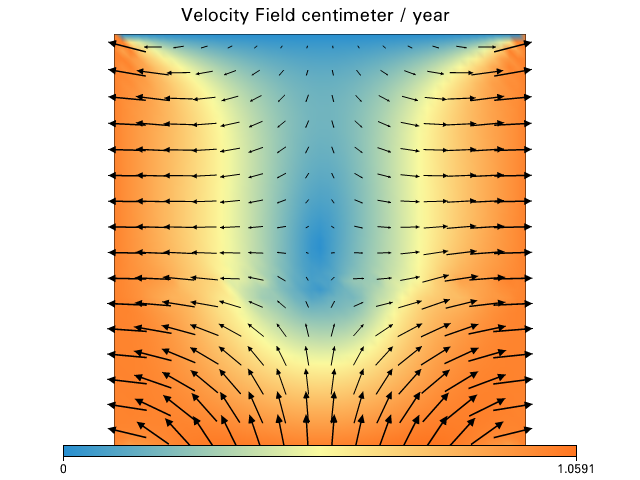


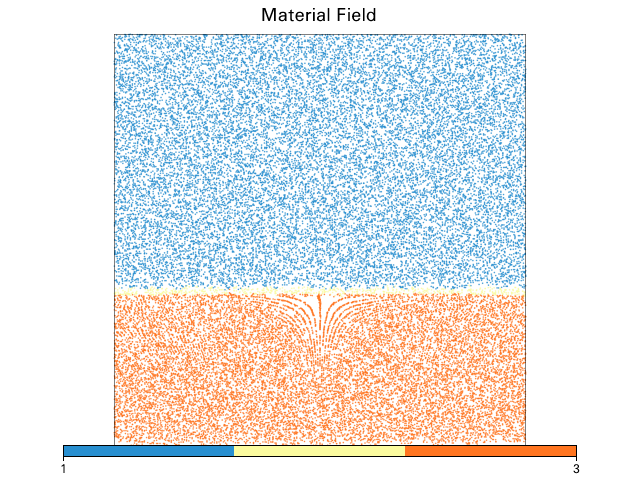

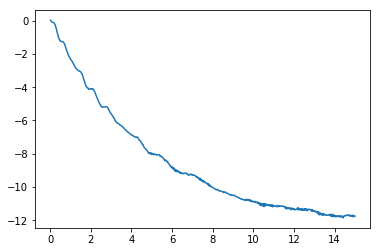

In [15]:
Fig = Model.plot.velocityField()
Fig = Model.plot.material(projected=False, fn_size=2.0)
np_htt = np.array(height_through_time)
plt.plot(np_htt[:,0], np_htt[:,1])

In [16]:
Model.run_for(5e6* u.year)

Running with UWGeodynamics version 0.9.3-dev-3c9372d(development)
Step:1 Model Time:  15023683.7739 year dt: 23683.7738623 year (2018-10-24 07:04:53)
Step:2 Model Time:  15048594.7742 year dt: 24911.0003579 year (2018-10-24 07:04:54)
Step:3 Model Time:  15071879.447 year dt: 23284.6727668 year (2018-10-24 07:04:56)
Step:4 Model Time:  15096772.7206 year dt: 24893.2736346 year (2018-10-24 07:04:57)
Step:5 Model Time:  15121617.6762 year dt: 24844.955567 year (2018-10-24 07:04:58)
Step:6 Model Time:  15142977.3903 year dt: 21359.7140968 year (2018-10-24 07:05:00)
Step:7 Model Time:  15167967.6002 year dt: 24990.2099427 year (2018-10-24 07:05:01)
Step:8 Model Time:  15186647.2767 year dt: 18679.6764326 year (2018-10-24 07:05:02)
Step:9 Model Time:  15211644.9019 year dt: 24997.6252222 year (2018-10-24 07:05:03)
Step:10 Model Time:  15232830.5497 year dt: 21185.6477733 year (2018-10-24 07:05:04)
Step:11 Model Time:  15257651.0925 year dt: 24820.5428485 year (2018-10-24 07:05:06)
Step:12 Mo

Step:98 Model Time:  17105245.4746 year dt: 24048.1211245 year (2018-10-24 07:07:00)
Step:99 Model Time:  17128947.668 year dt: 23702.1933999 year (2018-10-24 07:07:01)
Step:100 Model Time:  17153831.9684 year dt: 24884.300323 year (2018-10-24 07:07:02)
Step:101 Model Time:  17171430.801 year dt: 17598.8325927 year (2018-10-24 07:07:04)
Step:102 Model Time:  17196384.0918 year dt: 24953.2908825 year (2018-10-24 07:07:05)
Step:103 Model Time:  17213295.0545 year dt: 16910.9626549 year (2018-10-24 07:07:06)
Step:104 Model Time:  17238243.7303 year dt: 24948.6758344 year (2018-10-24 07:07:07)
Step:105 Model Time:  17258891.5944 year dt: 20647.8641055 year (2018-10-24 07:07:08)
Step:106 Model Time:  17283835.8943 year dt: 24944.2998951 year (2018-10-24 07:07:10)
Step:107 Model Time:  17305928.3956 year dt: 22092.501231 year (2018-10-24 07:07:11)
Step:108 Model Time:  17330868.7868 year dt: 24940.3911962 year (2018-10-24 07:07:12)
Step:109 Model Time:  17349552.2097 year dt: 18683.4229726 y

Step:194 Model Time:  19209536.3804 year dt: 22680.3091638 year (2018-10-24 07:08:59)
Step:195 Model Time:  19234079.9075 year dt: 24543.5270877 year (2018-10-24 07:09:01)
Step:196 Model Time:  19258979.2092 year dt: 24899.3017883 year (2018-10-24 07:09:02)
Step:197 Model Time:  19280108.6922 year dt: 21129.4829867 year (2018-10-24 07:09:04)
Step:198 Model Time:  19304941.4346 year dt: 24832.7423305 year (2018-10-24 07:09:05)
Step:199 Model Time:  19322396.3248 year dt: 17454.8902204 year (2018-10-24 07:09:06)
Step:200 Model Time:  19347256.4905 year dt: 24860.1657655 year (2018-10-24 07:09:07)
Step:201 Model Time:  19365956.7537 year dt: 18700.2631988 year (2018-10-24 07:09:09)
Step:202 Model Time:  19390751.2973 year dt: 24794.5435433 year (2018-10-24 07:09:10)
Step:203 Model Time:  19407627.0437 year dt: 16875.746395 year (2018-10-24 07:09:12)
Step:204 Model Time:  19432598.7225 year dt: 24971.6788171 year (2018-10-24 07:09:13)
Step:205 Model Time:  19455519.8145 year dt: 22921.0919

1


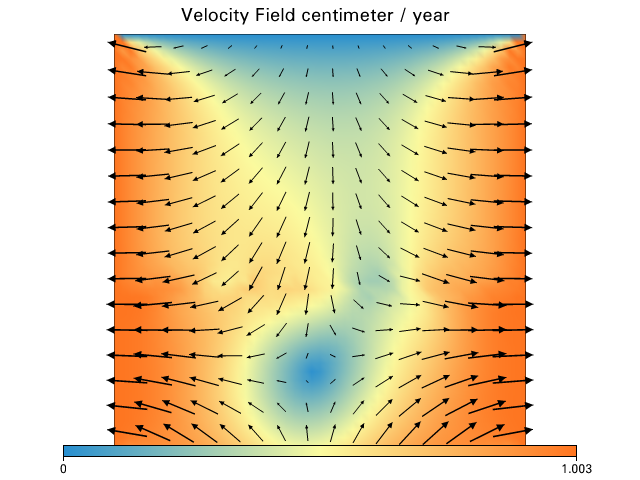


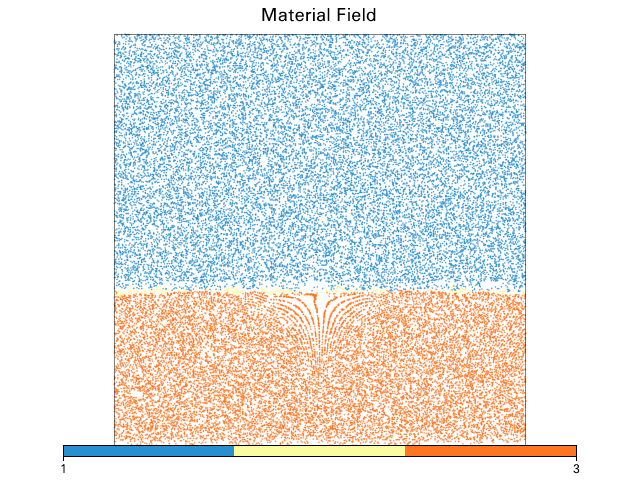

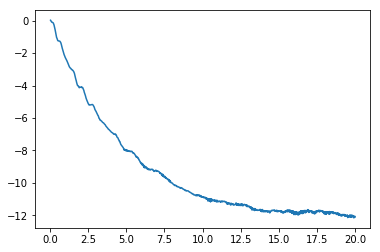

In [17]:
Fig = Model.plot.velocityField(rulers=True, rulerticks=5)
Fig = Model.plot.material(projected=False, fn_size=2.0,rulers=True, rulerticks=5)
np_htt = np.array(height_through_time)
plt.plot(np_htt[:,0], np_htt[:,1])

In [21]:
# Final position of particle
print GEO.Dimensionalize(mswarm.particleCoordinates.data[:,0].copy()[0], u.kilometer), GEO.Dimensionalize(mswarm.particleCoordinates.data[:,1].copy()[0], u.kilometer)

-9.58368853498 kilometer -12.1070601683 kilometer


# Summary

While things get a bit unstable at the end, we can see that the model tends towards the answer we predicted analytically, which is good!